In [ ]:
# --- Data Handling and File Operations ---
import pandas as pd
from pathlib import Path
import os
import kagglehub
from sklearn.model_selection import train_test_split
from collections import Counter

# --- Progress Visualization ---
from tqdm import tqdm

# --- Image Handling and Manipulation ---
from PIL import Image
import torchvision.transforms as transforms
from torchvision.io import read_image
import torchvision
import cv2

# --- Regular Expressions and Randomization ---
import re
import random
import numpy as np

# --- Metrics and Evaluation ---
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# --- PyTorch Core Libraries ---
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# --- Reproducibility ---
# Ensure reproducibility by setting seeds for random number generation
torch.manual_seed(409)
np.random.seed(409)
random.seed(409)
# Set CuBLAS workspace configuration for deterministic behavior
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Visualization ---
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

### Download data and create a dataframe containing the images and their corresponding labels

In [ ]:
# Download CIFAKE dataset
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

100%|██████████| 105M/105M [00:04<00:00, 25.3MB/s]

Extracting files...


In [ ]:
# Collect file paths and labels
file_paths = list(Path(path).glob('*/*/*.jpg'))
labels = [file.parent.name for file in file_paths]

# Create DataFrame
df = pd.DataFrame({"image": [str(file) for file in file_paths], "label": labels})

# Keep the last part of the string as title for image
df['image'] = df['image'].str.split('/').str[-1]

# Display the shape and size
print(f"Total files: {len(df)}, Shape of DataFrame: {df.shape}")

Total files: 120000, Shape of DataFrame: (120000, 2)


### Check if the dataset is balanced with repsect to the labels

In [ ]:
# Display the data
display(df)

,image,label
0,0508.jpg,REAL
1,0893.jpg,REAL
2,0644 (9).jpg,REAL
3,0299 (3).jpg,REAL
4,0246 (9).jpg,REAL
...,...,...
119995,3530 (7).jpg,FAKE
119996,5452 (9).jpg,FAKE
119997,2958 (2).jpg,FAKE
119998,1755 (8).jpg,FAKE


In [ ]:
# Determine the unique label classes
print(f"The unique labels are: {', '.join(map(str, df['label'].unique()))}")

The unique labels are: REAL, FAKE


In [ ]:
# Count occurrences of each label
label_counts = df['label'].value_counts()
print(label_counts)

label
REAL    60000
FAKE    60000
Name: count, dtype: int64


### Check if the dataset is balanced with repsect to the number of images in each subclass according to the CIFAR-10 dataset

In [ ]:
# Only show the name of the image file (excluding the path name)
df['image'] = df['image'].str.split('/').str[-1]

# Extract numbers inside parentheses
df['subclasses'] = df['image'].str.extract(r'\((\d+)\)')

# Ensure all filenames have a valid format and append '(1)' if missing
df['image'] = df['image'].apply(lambda x: x if '(' in x and ')' in x else x + ' (1)')

# Extract numbers inside parentheses
df['subclasses'] = df['image'].str.extract(r'\((\d+)\)').astype(int)

# Replace subclass to be 0-indexed
df['subclasses'] = df['subclasses'].apply(lambda x: x-1)

In [ ]:
# Determine the unique object classes
print(f"The unique subclasses are: {', '.join(map(str, df['subclasses'].unique()))}")

The unique subclasses are: 0, 8, 2, 9, 4, 3, 5, 6, 1, 7


In [ ]:
# Count number of samples with respect to subclasses
subclasses_counts = df['subclasses'].value_counts()

# Display the total number of distinct subclasses
print(f"The total number of distinct subclasses is: {len(subclasses_counts)}\n")

# Display subclass counts
print('The subclasses and their sample counts:\n')
print('-' * 25)

# Define column width and number of columns
# Width for subclass name
name_width = 19
# Width for count
count_width = 5
# Additional spacing between columns
spacing = 2
# Number of columns to display
columns = 1

# Prepare data: formatted subclass names and their counts
formatted_subclasses = [
    f"{f'Subclass {subclass}:':<{name_width}} {count:>{count_width}}"
    for subclass, count in zip(subclasses_counts.index, subclasses_counts.values)
]

# Split the subclasses into chunks for display
chunks = [formatted_subclasses[i:i + columns] for i in range(0, len(formatted_subclasses), columns)]

# Iterate over chunks and display rows
for chunk in chunks:
    print(' | '.join(chunk))
print('-' * 25)

# Check if all subclasses have the same number of samples
if subclasses_counts.nunique() == 1:
    print("\nAll subclasses have the same number of samples.")
else:
    print("\nNot all subclasses have the same number of samples.")

The total number of distinct subclasses is: 10

The subclasses and their sample counts:

-------------------------
Subclass 0:         12000
Subclass 8:         12000
Subclass 2:         12000
Subclass 9:         12000
Subclass 4:         12000
Subclass 3:         12000
Subclass 5:         12000
Subclass 6:         12000
Subclass 1:         12000
Subclass 7:         12000
-------------------------

All subclasses have the same number of samples.


### Retrieve test and training set, then split training data into training and validation set

In [ ]:
# Define paths for training and testing folders
train_folder = Path(path) / "train"
test_folder = Path(path) / "test"

In [ ]:
# Get all file paths in the train and test folder
train_set_paths = list(train_folder.glob('*/*.jpg'))
test_set_paths = list(test_folder.glob('*/*.jpg'))

# Split into training and validation file paths and stratify by label
labels = [p.parent.name for p in train_set_paths]
train_set_paths, val_set_paths = train_test_split(train_set_paths, test_size = 0.2, random_state = 904, stratify = labels)

In [ ]:
# Collect labels for each subset
train_labels = [file.parent.name for file in train_set_paths]
val_labels = [file.parent.name for file in val_set_paths]
test_labels = [file.parent.name for file in test_set_paths]

# Create DataFrames for each subset
df_train = pd.DataFrame({"image": [str(file) for file in train_set_paths], "label": train_labels})
df_val = pd.DataFrame({"image": [str(file) for file in val_set_paths], "label": val_labels})
df_test = pd.DataFrame({"image": [str(file) for file in test_set_paths], "label": test_labels})

# Function to display label counts
def display_label_counts(label_counts, set_name):

    # Define column width
    column_width = 16

    # Print header
    print(f"\n{set_name} set:")
    print(f"{'Label'.ljust(column_width)}{'Count'}")
    print('-' * (column_width + 5))

    # Print each label and count
    for label, count in label_counts.items():
        print(f"{label.ljust(column_width)}{count}")
    print('-' * (column_width + 5))

# Count occurrences of each label
# Training set
label_counts_train = df_train['label'].value_counts()
display_label_counts(label_counts_train, "Training")

# Validation set
label_counts_val = df_val['label'].value_counts()
display_label_counts(label_counts_val, "Validation")

# Test set
label_counts_test = df_test['label'].value_counts()
display_label_counts(label_counts_test, "Test")


Training set:
Label           Count
---------------------
REAL            40000
FAKE            40000
---------------------

Validation set:
Label           Count
---------------------
REAL            10000
FAKE            10000
---------------------

Test set:
Label           Count
---------------------
REAL            10000
FAKE            10000
---------------------


### Pre-process data

The $\texttt{compute_mean_std}$ function calculates the mean and standard deviation of pixel values across all images in the given subset. It processes each image, normalizes pixel values to the range [0, 1], and computes the per-channel (R, G, B) statistics. The averages are then returned as tensors for use in dataset normalization.

In [ ]:
def compute_mean_std(file_paths):

    # Initialize tensors to store the cumulative mean and standard deviation for each channel (R, G, B)
    mean = torch.zeros(3)
    std = torch.zeros(3)

    # Loop through each file path
    for file_path in tqdm(file_paths):

        # Read the image and normalize it to [0, 1]
        image = read_image(str(file_path)).float() / 255.0

        # Compute the mean of pixel values for each channel (R, G, B)
        # across the spatial dimensions (height and width)
        mean += image.mean(dim = (1, 2))

        # Compute the standard deviation of pixel values for each channel (R, G, B)
        # across the spatial dimensions (height and width)
        std += image.std(dim = (1, 2))

    # Divide the cumulative mean by the total number of images
    # to get the average mean for each channel
    mean /= len(file_paths)

    # Divide the cumulative standard deviation by the total number of images
    # to get the average standard deviation for each channel
    std /= len(file_paths)

    # Return the computed mean and standard deviation for all channels
    return mean, std

The $\texttt{CIFAKE_Dataset}$ class is a custom PyTorch dataset for loading images and their corresponding labels. It maps file paths to integer class labels, scales image pixel values to the range [0, 1], and applies optional transformations. The dataset provides the length of the dataset and retrieves an image and its label when indexed.

In [ ]:
class CIFAKE_Dataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform
        # Map each class name to an integer label
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(set(p.parent.name for p in file_paths))}

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path = self.file_paths[idx]
        # Convert to float and scale
        image = torchvision.io.read_image(str(image_path)).float() / 255.0
        # Apply transforms if provided
        if self.transform:
          image = self.transform(image)

        # Map the class name to an integer
        label = self.class_to_idx[image_path.parent.name]

        return image, label

### Create network architecture for CNN

The $\texttt{ConvBlock}$ class defines a reusable building block for convolutional layers in a neural network, combining a 2D convolution, activation (ReLU), max pooling, batch normalization, and dropout. This modular design simplifies creating CNN architectures.

The $\texttt{CNN}$ class is a convolutional neural network designed for image classification. It comprises 4 convolutional blocks for feature extraction, global average pooling for dimensionality reduction, and 2 fully connected layers for final classification. The network is equipped with batch normalization, dropout, and weight initialization to ensure robust and efficient training.

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, pool_kernel = 2, dropout = 0.3):
        super(ConvBlock, self).__init__()
        # Sequential block
        self.block = nn.Sequential(
            # Convolutional layer
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            # Activation function
            nn.ReLU(),
            # Max pooling for down-sampling
            nn.MaxPool2d(kernel_size = pool_kernel, stride = pool_kernel),
            # Batch normalization to stabilize training
            nn.BatchNorm2d(out_channels),
            # Dropout for regularization
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Forward pass through the block
        return self.block(x)


class CNN(nn.Module):
    def __init__(self, num_classes, height, width):
        super(CNN, self).__init__()
        # Input parameters
        self.num_classes = num_classes
        self.height = height
        self.width = width

        # Define convolutional blocks
        # First block: input channels = 3 (RGB), output channels = 32
        self.conv_1 = ConvBlock(3, 32)
        # Second block: input = 32 channels, output = 64 channels
        self.conv_2 = ConvBlock(32, 64)
        # Third block: input = 64 channels, output = 128 channels
        self.conv_3 = ConvBlock(64, 128)
        # Fourth block without max-pooling: input = 128 channels, output = 256 channels
        self.conv_4 = nn.Sequential(
            # Convolutional layer
            nn.Conv2d(128, 256, 3, 1, 1),
            # Activation function
            nn.ReLU(),
            # Batch normalization to stabilize training
            nn.BatchNorm2d(256),
            # Dropout for regularization
            nn.Dropout(0.3)
        )

        # Global average pooling layer
        # Reduces spatial dimensions to 1x1
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Define fully connected layers
        # First block: input = 256, output = 64
        self.fc1 = nn.Sequential(
            # Fully connected layer
            nn.Linear(256, 64),
            # Activation function
            nn.ReLU(),
            # Batch normalization to stabilize training
            nn.BatchNorm1d(64),
            # Dropout for regularization
            nn.Dropout(0.5)
        )

        # Final fully connected layer: input = 64, output = number of classes
        self.fc2 = nn.Linear(64, num_classes)

        # Apply appropriate weight initialization to the layers for better convergence
        def init_weights(layer):
          # Initialize convolutional layers
          if isinstance(layer, nn.Conv2d):
              nn.init.kaiming_normal_(layer.weight, mode = 'fan_out', nonlinearity = 'relu')
          # Initialize fully connected layers
          elif isinstance(layer, nn.Linear):
              nn.init.xavier_normal_(layer.weight)

        # Initialize weights
        self.apply(init_weights)

    def forward(self, x_img):
        # Pass input through convolutional blocks
        x_img = self.conv_1(x_img)
        x_img = self.conv_2(x_img)
        x_img = self.conv_3(x_img)
        x_img = self.conv_4(x_img)

        # Apply global average pooling layer
        x_img = self.global_avg_pool(x_img)
        # Flatten layer
        x_img = x_img.view(x_img.size(0), -1)

        # Pass through fully connected layers
        x_img = self.fc1(x_img)
        x_img = self.fc2(x_img)

        # Return the final output
        return x_img

### Train the model

The $\texttt{train_model}$ function trains a model over a specified number of epochs while tracking performance metrics such as loss and accuracy for both training and validation datasets. It incorporates a learning rate scheduler for dynamic adjustments and early stopping to halt training when validation performance stops improving for a specified patience period. Metrics (loss and accuracy) are logged at each epoch and stored in a history dictionary for analysis. If early stopping is triggered, the model reverts to the state with the best validation loss.

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs, device, patience = 15):

    # Initialize a dictionary to store training and validation metrics
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    # Set the initial best validation loss to infinity for comparison
    best_val_loss = float('inf')

    # Initialize the patience counter for early stopping
    patience_counter = 0

    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        # Print the current epoch
        print(f"Epoch {epoch + 1}/{num_epochs}")
        # Separator line
        print("-" * 55)

        # --- Training Phase ---
        # Set the model to training mode
        model.train()
        # Initialize metrics for training
        train_loss, correct_train, total_train = 0.0, 0, 0

        # Iterate over the training data batches
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Reset gradients from the previous step
            optimizer.zero_grad()
            # Forward pass through the model
            outputs = model(images)
            # Compute the loss
            loss = loss_fn(outputs, labels)
            # Backward pass to compute gradients
            loss.backward()
            # Update model weights based on gradients
            optimizer.step()

            # Accumulate training loss
            train_loss += loss.item()
            # Get the predicted classes (highest logit value)
            _, predicted = torch.max(outputs, 1)
            # Count correct predictions
            correct_train += (predicted == labels).sum().item()
            # Count the total number of samples
            total_train += labels.size(0)

        # Compute training accuracy and average loss
        train_accuracy = correct_train / total_train
        avg_train_loss = train_loss / len(train_loader)
        # Save metrics to history
        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_accuracy)

        # --- Validation Phase ---
        # Set the model to evaluation mode
        model.eval()
        # Initialize metrics for validation
        val_loss, correct_val, total_val = 0.0, 0, 0

        # Disable gradient computation for validation to save memory and speed up computation
        with torch.no_grad():
            # Iterate over the validation data batches
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass through the model
                outputs = model(images)
                # Compute the loss
                loss = loss_fn(outputs, labels)

                # Accumulate validation loss
                val_loss += loss.item()
                # Get the predicted classes
                _, predicted = torch.max(outputs, 1)
                # Count correct predictions
                correct_val += (predicted == labels).sum().item()
                # Count the total number of samples
                total_val += labels.size(0)

        # Compute validation accuracy and average loss
        val_accuracy = correct_val / total_val
        avg_val_loss = val_loss / len(val_loader)

        # Save metrics to history
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_accuracy)

        # --- Learning Rate Scheduler ---
        # Adjust learning rate based on validation loss
        scheduler.step(avg_val_loss)

        # Log the current learning rate manually
        current_lr = scheduler.optimizer.param_groups[0]['lr']


        # --- Logging ---
        # Log current learning rate
        print(f"Current Learning Rate: {current_lr:.8f} \n")
        # Header with aligned columns
        print(f"{'Metric':<20}{'Train':<20}{'Validation':<20}")
        # Separator line
        print(f"{'-' * 55}")
        # Log loss values
        print(f"{'Loss':<20}{avg_train_loss:<20.3f}{avg_val_loss:<20.3f}")
        # Log accuracy values
        print(f"{'Accuracy':<20}{train_accuracy:<20.3f}{val_accuracy:<20.3f}")
        # Separator line
        print("-" * 55)
        print("\n")

        # --- Early Stopping ---
        # Check if validation loss has improved
        if avg_val_loss < best_val_loss:
            # If so, update the best validation loss
            best_val_loss = avg_val_loss
            # Reset patience counter
            patience_counter = 0
            # Save the best model state
            best_model_state = model.state_dict()
        else:
            # If not, increment the patience counter
            patience_counter += 1
            # Check if patience limit is reached
            if patience_counter >= patience:
                # If so, log early stopping
                print(f"Early stopping at epoch {epoch + 1}")
                # Load the best model state
                model.load_state_dict(best_model_state)
                # Exit the training loop
                break

    # Return the training and validation metrics history
    return history

### Main script

This script implements a pipeline for training and evaluating the CNN. It includes the following steps:

1. Device Selection:
  - Automatically selects GPU if available; otherwise, it uses the CPU.
2. Dataset Preparation:
  - Computes mean and standard deviation for dataset normalization.
  - Applies transformations and creates training, validation, and test datasets.
  - DataLoaders handle batching and shuffling for efficient data feeding.

3. Model Setup:
  - Initializes a CNN model, loss function (CrossEntropyLoss), and optimizer (AdamW with weight decay for regularization).

  - Implements a learning rate scheduler (ReduceLROnPlateau) to dynamically adjust the learning rate based on validation loss.

4. Training and Evaluation:
  - The train_model function trains the model over a specified number of epochs, logging training and validation loss and accuracy.
  - Early stopping and learning rate adjustments are incorporated to improve efficiency.

5. Visualization:
  - Loss and accuracy for training and validation are plotted side-by-side to evaluate model performance.
  - Plots are saved as an image file (cnn_crossentropy_training.png) and displayed for analysis.

In [ ]:
# Set the device to GPU if available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --- Transform and datasets ---
# Compute the mean and standard deviation
mean, std = (compute_mean_std(train_set_paths))
# Define a transformation pipeline with normalization
transform = transforms.Compose([transforms.Normalize(mean, std)])

# Create training, validation, and test datasets
train_set = CIFAKE_Dataset(train_set_paths, transform = transform)
val_set = CIFAKE_Dataset(val_set_paths, transform = transform)
test_set = CIFAKE_Dataset(test_set_paths, transform = transform)

# Training loader: batches of 64, with shuffling for better generalization
train_loader = DataLoader(train_set, batch_size = 64, shuffle = True)
# Validation loader: batches of 64, no shuffling
val_loader = DataLoader(val_set, batch_size = 64, shuffle = False)
# Test loader: batches of 64, no shuffling
test_loader = DataLoader(test_set, batch_size = 64, shuffle = False)


# --- Model, loss, optimizer and scheduler ---
# Input image dimensions
height, width = (32, 32)
# Number of classes (binary classification)
num_classes = 2

# Instantiate the CNN model
model = CNN(num_classes, height, width).to(device)
# Define the loss function
loss_fn = nn.CrossEntropyLoss()
# Define the optimizer: AdamW with a learning rate of 0.001 and weight decay for regularization
optimizer = optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 1e-4)
# Define the learning rate scheduler: ReduceLROnPlateau reduces the learning rate when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 3)


# --- Train and evaluate ---
# Set the number of training epochs
num_epochs = 100
# Train the model and save the training and validation history
history = train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs, device)

100%|██████████| 80000/80000 [00:16<00:00, 4758.36it/s]


Epoch 1/100
-------------------------------------------------------
Current Learning Rate: 0.00100000 

Metric              Train               Validation          
-------------------------------------------------------
Loss                0.320               0.570               
Accuracy            0.868               0.781               
-------------------------------------------------------


Epoch 2/100
-------------------------------------------------------
Current Learning Rate: 0.00100000 

Metric              Train               Validation          
-------------------------------------------------------
Loss                0.220               0.401               
Accuracy            0.913               0.845               
-------------------------------------------------------


Epoch 3/100
-------------------------------------------------------
Current Learning Rate: 0.00100000 

Metric              Train               Validation          
---------------------------------

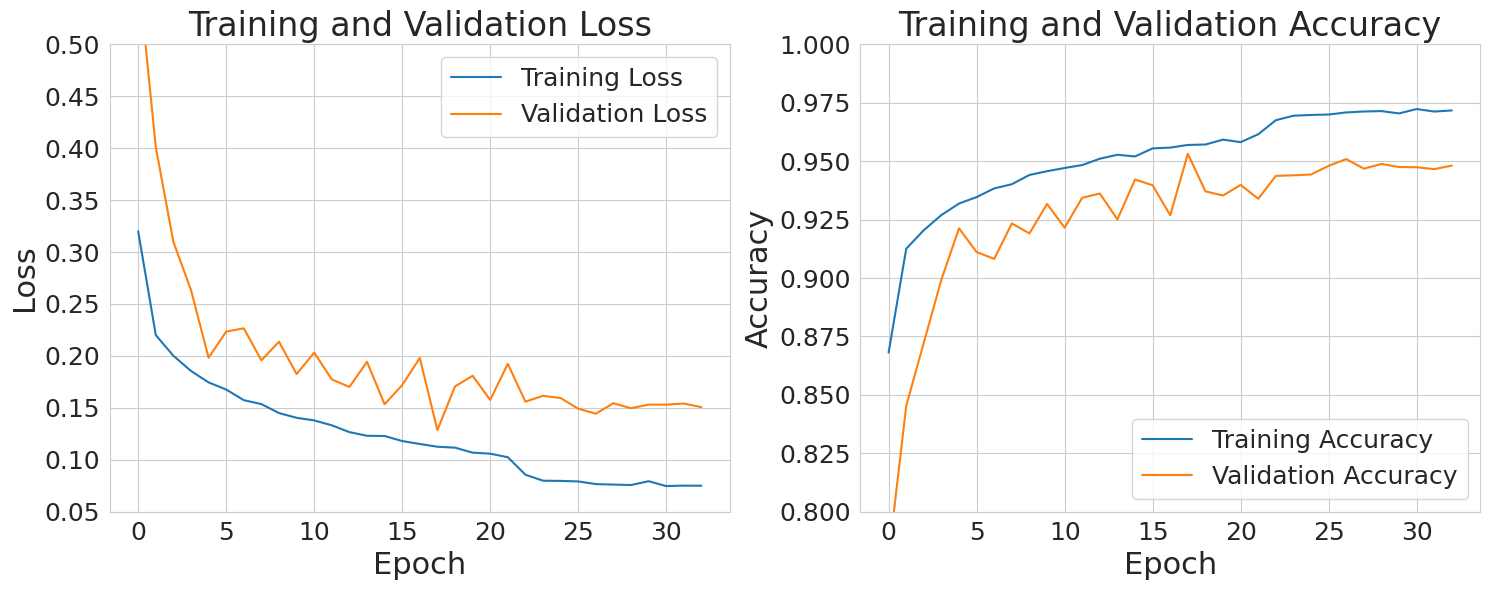

In [ ]:
# --- Plot results ---
# Create a figure for side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

# Plot Training and Validation Loss
axes[0].plot(history["train_loss"], label = "Training Loss")
axes[0].plot(history["val_loss"], label = "Validation Loss")
axes[0].set_xlabel("Epoch", fontsize = 22)
axes[0].set_ylim(0.05, 0.5)
axes[0].set_ylabel("Loss", fontsize = 22)
axes[0].set_title("Training and Validation Loss", fontsize = 24)
axes[0].legend(fontsize = 18, loc = 'upper right')
axes[0].tick_params(axis = 'both', which = 'major', labelsize = 18)

# Plot Training and Validation Accuracy
axes[1].plot(history["train_acc"], label = "Training Accuracy")
axes[1].plot(history["val_acc"], label = "Validation Accuracy")
axes[1].set_xlabel("Epoch", fontsize = 22)
axes[1].set_ylim(0.80, 1)
axes[1].set_ylabel("Accuracy", fontsize = 22)
axes[1].set_title("Training and Validation Accuracy", fontsize = 24)
axes[1].legend(fontsize = 18, loc = 'lower right')
axes[1].tick_params(axis = 'both', which = 'major', labelsize = 18)

# Display the plots
plt.tight_layout()
# Save figure
plt.savefig('cnn_cross_entropy_training.png', format = 'png')
plt.show()

### Evaluate the model

The $\texttt{evaluate_model_on_test}$ function evaluates the trained model on the test data to measure its performance.
It computes the test loss, accuracy, precision, recall, and F1 Score.
The function operates in evaluation mode, disables gradient calculations, and processes the test dataset in batches. Results are displayed in a formatted table and returned for further analysis.

This function provides a comprehensive assessment of the model's effectiveness on unseen data.

In [ ]:
# Evaluate model on test data
def evaluate_model_on_test(model, test_loader, loss_fn):

    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track the total test loss, correct predictions, and total samples
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    # Initialize list to store true labels
    all_labels = []
    # Initialize list to store predicted labels
    all_predictions = []

    # Disable gradient computations to save memory and improve evaluation speed
    with torch.no_grad():
        # Iterate over the test data batches
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass through the model
            outputs = model(images)

            # Compute the loss
            loss = loss_fn(outputs, labels)
            # Accumulate the total test loss
            test_loss += loss.item()

            # Get the predicted classes (highest logit value)
            _, predicted = torch.max(outputs, 1)
            # Count correct predictions
            correct_test += (predicted == labels).sum().item()
            # Count the total number of samples
            total_test += labels.size(0)

            # Collect all labels and predictions for precision, recall, and F1
            # Move to CPU and convert to NumPy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute the average test loss by dividing the total loss by the number of batches
    test_loss /= len(test_loader)
    # Compute the test accuracy as the ratio of correct predictions to total samples
    test_accuracy = correct_test / total_test

    # Compute precision, recall, and F1 score
    # average = "macro" computes these metrics for each class and takes the unweighted mean
    precision = precision_score(all_labels, all_predictions, average = "macro")
    recall = recall_score(all_labels, all_predictions, average = "macro")
    f1 = f1_score(all_labels, all_predictions, average = "macro")

    # Display results
    column_width = 18
    print(f"{'Metric'.ljust(column_width)}{'Value'}")
    print(23 * '-')
    print(f"{'Loss'.ljust(column_width)}{test_loss:.3f}")
    print(f"{'Accuracy'.ljust(column_width)}{test_accuracy:.3f}")
    print(f"{'Precision'.ljust(column_width)}{precision:.3f}")
    print(f"{'Recall'.ljust(column_width)}{recall:.3f}")
    print(f"{'F1 Score'.ljust(column_width)}{f1:.3f}")

    # Return the test loss, accuracy, precision, recall and f1-score
    return test_loss, test_accuracy, precision, recall, f1

# Evaluate the model on the test set
test_loss, test_accuracy, precision, recall, f1 = evaluate_model_on_test(model, test_loader, loss_fn)

Metric            Value
-----------------------
Loss              0.137
Accuracy          0.952
Precision         0.954
Recall            0.952
F1 Score          0.951


The $\texttt{plot_confusion_matrix_with_metrics}$ function visualizes the performance of the trained model on the test data using a confusion matrix by:

1. Prediction Collection:
  - The model is set to evaluation mode, and predictions are collected for all test samples.
  - True labels and predicted labels are stored after processing the test dataset in batches.

2. Confusion Matrix:
  - Summarizes prediction performance across all classes.
  - Normalizes the confusion matrix to display percentages for better interpretability.

3. Visualization:
  - The confusion matrix is displayed as a heatmap with both counts and percentages annotated within the cells.
  - True Label vs. Predicted Label

4. Output:
  - The plot is saved as cnn_crossentropy_cm.png and displayed, providing insights into the model's strengths and weaknesses in classifying each category.

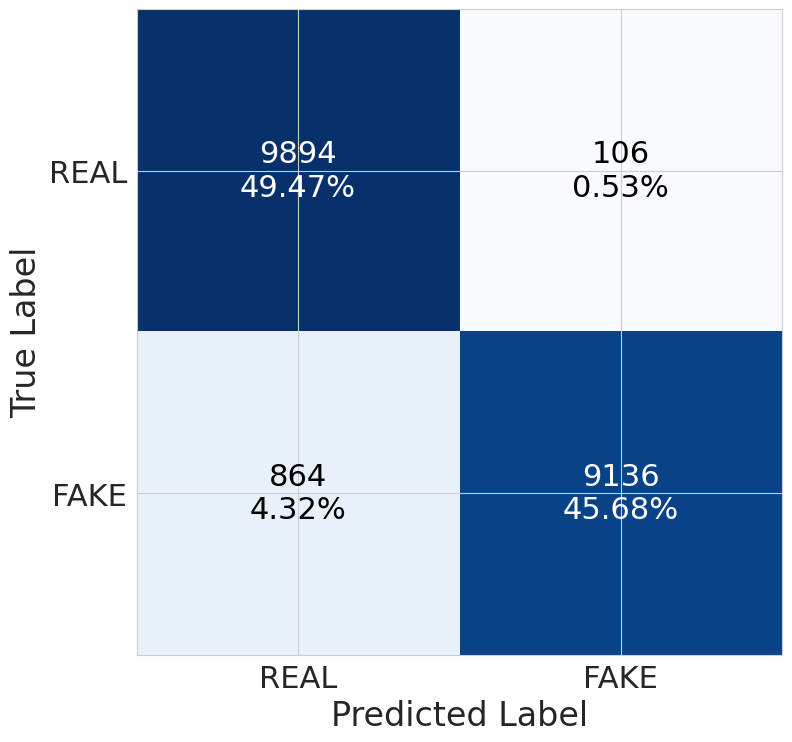

In [ ]:
# Create confusion matrix to visualize the evalution of model on test data
def plot_confusion_matrix_with_metrics(model, test_loader, class_names):

    # Set the model to evaluation mode
    device = "cuda"
    model = model.to(device)
    model.eval()

    # Initialize list to store true labels
    all_labels = []
    # Initialize list to store predicted labels
    all_predictions = []

    # Disable gradient computations to save memory and improve evaluation speed
    with torch.no_grad():
        # Iterate over the test data batches
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass through the model
            outputs = model(images)
            # Get the predicted classes (highest logit value)
            _, predicted = torch.max(outputs, 1)

            # Collect all labels and predictions for precision, recall, and F1
            # Move to CPU and convert to NumPy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels = range(len(class_names)))

    # Normalize confusion matrix for percentages
    cm_percentage = cm.astype('float') / cm.sum() * 100

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize = (8, 8))
    im = ax.imshow(cm_percentage, interpolation = "nearest", cmap = plt.cm.Blues)

    # Add text annotations inside the boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]}\n{cm_percentage[i, j]:.2f}%",
                    ha="center", va="center", fontsize = 22, color="white" if cm_percentage[i, j] > 40 else "black")

    # Set axis labels and title
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names, fontsize = 22)
    ax.set_yticklabels(class_names, fontsize = 22)
    ax.set_xlabel("Predicted Label", fontsize = 24)
    ax.set_ylabel("True Label", fontsize = 24)
    plt.tight_layout()
    # Save figure
    plt.savefig('cnn_cross_entropy_cm.png', format = 'png')
    plt.show()


# Define class names
class_names = ["REAL", "FAKE"]
plot_confusion_matrix_with_metrics(model, test_loader, class_names)

### Compute GradCAM

The $\texttt{gradcam}$ function computes a GradCAM (Gradient-weighted Class Activation Mapping) heatmap for a specific input image and target class.
GradCAM visualizes the regions of an image that contribute most to the model's prediction for a particular class.

In [ ]:
# Compute GradCAM heatmap
def gradcam(model, image, label_idx, layer_name, device):

    # Set the model to evaluation mode
    model.eval()

    # Initialize an empty list to store gradients
    gradients = []
    # Initialize an empty list to store activations
    activations = []

    # Define hook function to capture gradients flowing backward
    def backward_hook(module, grad_in, grad_out):
        # Store the gradients of the layer's output
        gradients.append(grad_out[0])

    # Define hook function to capture activations during the forward pass
    def forward_hook(module, input, output):
        # Store the activations of the layer
        activations.append(output)

    # Iterate over all the named modules within the model
    for name, module in model.named_modules():
        # Check if the layer name matches the target layer
        if name == layer_name:
            # Register the forward hook
            module.register_forward_hook(forward_hook)
            # Register the backward hook
            module.register_backward_hook(backward_hook)

    # Add a batch dimension
    image = image.unsqueeze(0).to(device)

    # Forward pass
    output = model(image)
    # Select the output corresponding to the target class
    loss = output[0, label_idx]

    # Zero out gradients before the backward pass
    model.zero_grad()
    # Backward pass
    loss.backward()

    # Extract the gradients and activations
    grads = gradients[0].detach().cpu().numpy()
    acts = activations[0].detach().cpu().numpy()

    # Compute global average pooling of gradients over spatial dimensions
    weights = np.mean(grads, axis=(2, 3))
    # Compute weighted sum of activations
    cam = np.sum(weights[:, :, np.newaxis, np.newaxis] * acts, axis = 1)

    # Apply ReLU to remove negative values
    cam = np.maximum(cam, 0)
    # Remove the batch dimension
    cam = cam[0]
    # Normalize the heatmap to the range [0, 1]
    cam /= cam.max()

    # Return the GradCAM heatmap
    return cam

### Visualize GradCAM

The $\texttt{visualize_gradcam_subplot}$ function is designed to visualize GradCAM results for multiple images in a subplot format. It provides an intuitive and interpretable layout by displaying three columns for each input image:

1. The original image
2. The corresponding heatmap highlighting important regions for the model's prediction
3. An overlay of the heatmap on the original image

In [ ]:
# Compute the mean and standard deviation for all channels in test data
mean, std = compute_mean_std(test_set_paths)

# Compute the overall average of the mean tensor across all channels
average_mean = torch.mean(mean).item()

# Compute the overall average of the standard deviation tensor across all channels
average_std = torch.mean(std).item()

100%|██████████| 20000/20000 [00:03<00:00, 5108.30it/s]


In [ ]:
# Visualize GradCAM results in a subplot format
def visualize_gradcam_subplot(images, heatmaps, titles, average_mean, average_std, alpha = 0.4):

    # Number of rows in the subplot based on the number of images
    rows = len(images)
    # Original, Heatmap, Overlay
    cols = 3
    # Create figure with size proportional to the number of rows
    plt.figure(figsize = (10, 4 * rows))

    # Iterate over each image, its corresponding heatmap, and the title
    # i tracks the current iteration
    for i, (image, heatmap, title) in enumerate(zip(images, heatmaps, titles)):

        # Rearrange the dimensions to (height, width, channels)
        # Denormalize the image using mean and std
        img = image.permute(1, 2, 0).numpy() * average_std + average_mean
        # Clip the pixel values of the image to the range [0, 1]
        img = np.clip(img, 0, 1)

        # Resize the heatmap to match the spatial dimensions of the image
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        # Convert the heatmap to an RGB heatmap and scale values to the range [0, 255]
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        # Convert BGR to RGB and normalize the heatmap values to the range [0, 1]
        heatmap_colored = heatmap_colored[..., ::-1] / 255.0
        # Create an overlay of the original image and the heatmap by blending with alpha
        # Clip the resulting pixel values to the range [0, 1]
        overlayed = np.clip(img + alpha * heatmap_colored, 0, 1)

        # Calculate row index
        row_index = i

        # Add a title for the row at the center column
        plt.subplot(rows, cols, i * cols + 2)
        plt.text(x = 0.5, y = 1.17, s = title, fontsize = 24, ha = "center", transform = plt.gca().transAxes)

        # Plot Original Image
        plt.subplot(rows, cols, i * cols + 1)
        plt.imshow(img)
        plt.title("Original", fontsize = 22)
        plt.axis('off')

        # Plot Heatmap
        plt.subplot(rows, cols, i * cols + 2)
        plt.imshow(heatmap_resized, cmap = "jet")
        plt.title("Heatmap", fontsize = 22)
        plt.axis('off')

        # Plot Overlayed Image
        plt.subplot(rows, cols, i * cols + 3)
        plt.imshow(overlayed)
        plt.title("Overlay", fontsize = 22)
        plt.axis('off')

    plt.tight_layout()
    # Ensure enough space for row titles
    plt.subplots_adjust(top = 0.8, hspace = 0.3, wspace = 0.1)
    # Add overall title to plot
    plt.suptitle("Interpreting CNN Decisions Using Grad-CAM", fontsize = 28, y = 0.88)
    # Save figure
    plt.savefig("cnn_cross_entropy_gradcam.png", format = "png")
    plt.show()

### Generate GradCAM visualizations for each prediction case

The $\texttt{generate_gradcam_visualizations}$ function computes and visualizes GradCAM heatmaps for specific prediction cases based on a model's output. It systematically identifies examples for each case and visualizes the regions of input images that were most influential in the model's decisions.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


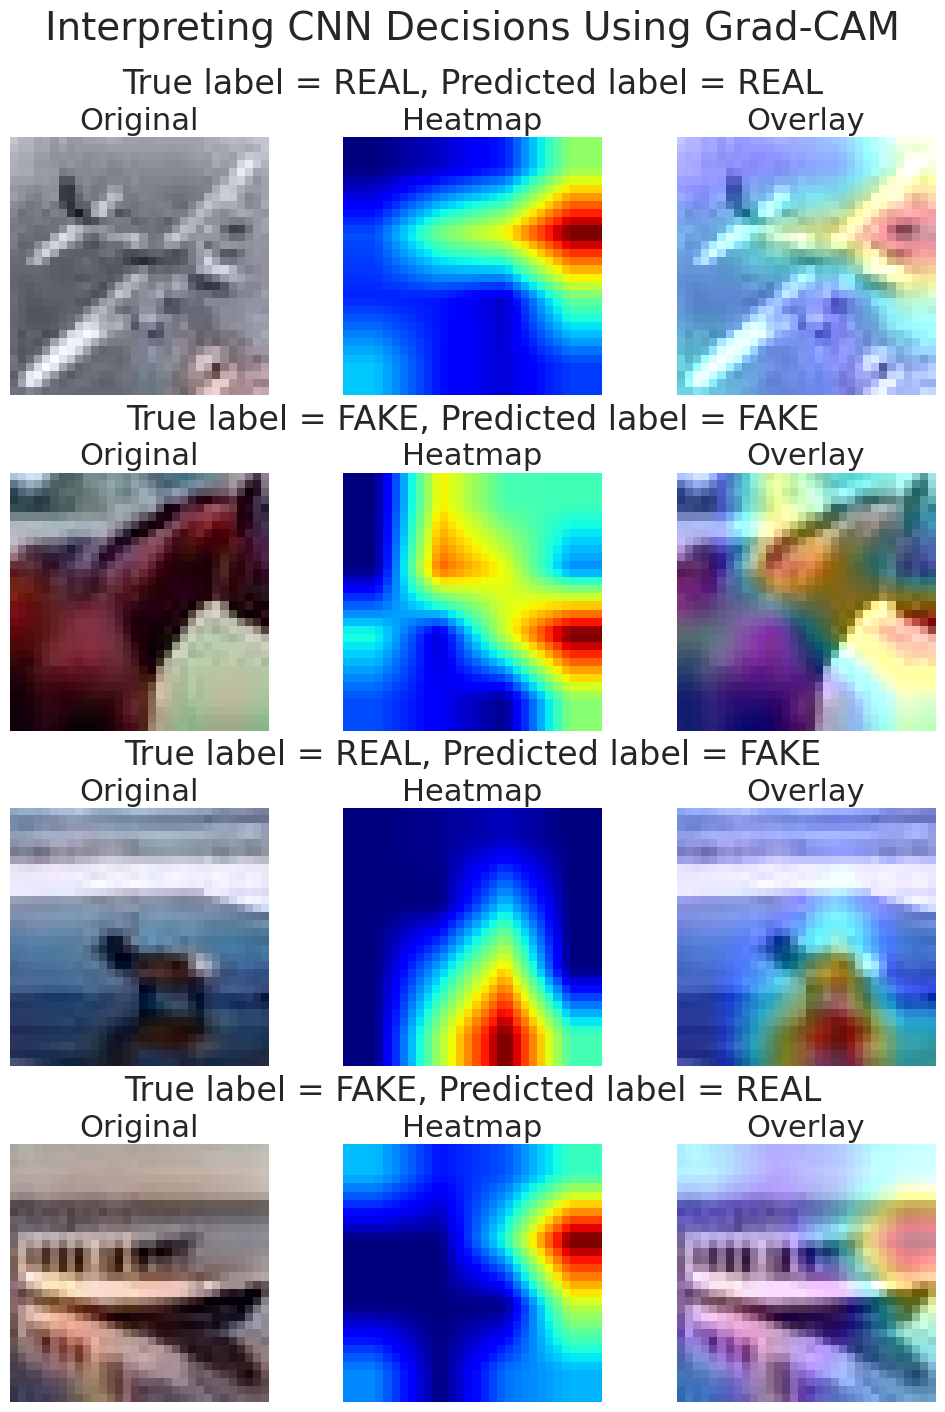

In [ ]:
# Generate GradCAM visualizations for each prediction case
def generate_gradcam_visualizations(model, test_loader, layer_name, device, average_mean, average_std):

    # Move the model to the specified computation device
    model = model.to(device)
    # Set the model to evaluation mode
    model.eval()

    # Define cases and conditions
    case_definitions = {
        "True label = REAL, Predicted label = REAL": lambda true, pred: true == 0 and pred == 0,
        "True label = FAKE, Predicted label = FAKE": lambda true, pred: true == 1 and pred == 1,
        "True label = REAL, Predicted label = FAKE": lambda true, pred: true == 0 and pred == 1,
        "True label = FAKE, Predicted label = REAL": lambda true, pred: true == 1 and pred == 0,
    }

    # Create dictionaries to store the first matching image and GradCAM heatmap for each case
    case_images = {case: None for case in case_definitions.keys()}
    case_heatmaps = {case: None for case in case_definitions.keys()}

    # Iterate over each case and its corresponding condition
    for case, condition in case_definitions.items():
        # Iterate over batches of images and labels from the test set
        for images_batch, labels_batch in test_loader:
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)

            # Forward pass
            outputs = model(images_batch)
            # Get the predicted class
            preds = torch.argmax(outputs, dim = 1)

            # Iterate over individual images, their true labels, and predicted labels in the batch
            for img, true_label, pred_label in zip(images_batch, labels_batch, preds):
                # Check if the current sample matches the condition for the case
                if condition(true_label.item(), pred_label.item()):
                    # Compute GradCAM heatmap
                    heatmap = gradcam(model, img, label_idx = int(true_label.item()), layer_name = layer_name, device = device)

                    # Store the first matching instance for the case
                    # Save the image and its corresponding heatmap for the current case
                    case_images[case] = img.cpu()
                    case_heatmaps[case] = heatmap
                    # Break when one instance is found for the case
                    break

            # Stop searching in the test set when a matching image is found for the current case
            if case_images[case] is not None:
                break

    # Collect the stored images, heatmaps, and case titles into lists for visualization
    images = [case_images[case] for case in case_definitions.keys()]
    heatmaps = [case_heatmaps[case] for case in case_definitions.keys()]
    titles = list(case_definitions.keys())

    # Visualize results
    visualize_gradcam_subplot(images, heatmaps, titles, average_mean, average_std)

# Visualize GradCAM for the last convolutional layer
generate_gradcam_visualizations(model, test_loader, layer_name = 'conv_4', device = "cpu", average_mean = average_mean, average_std = average_std)

### Implement old version of Grad-CAM

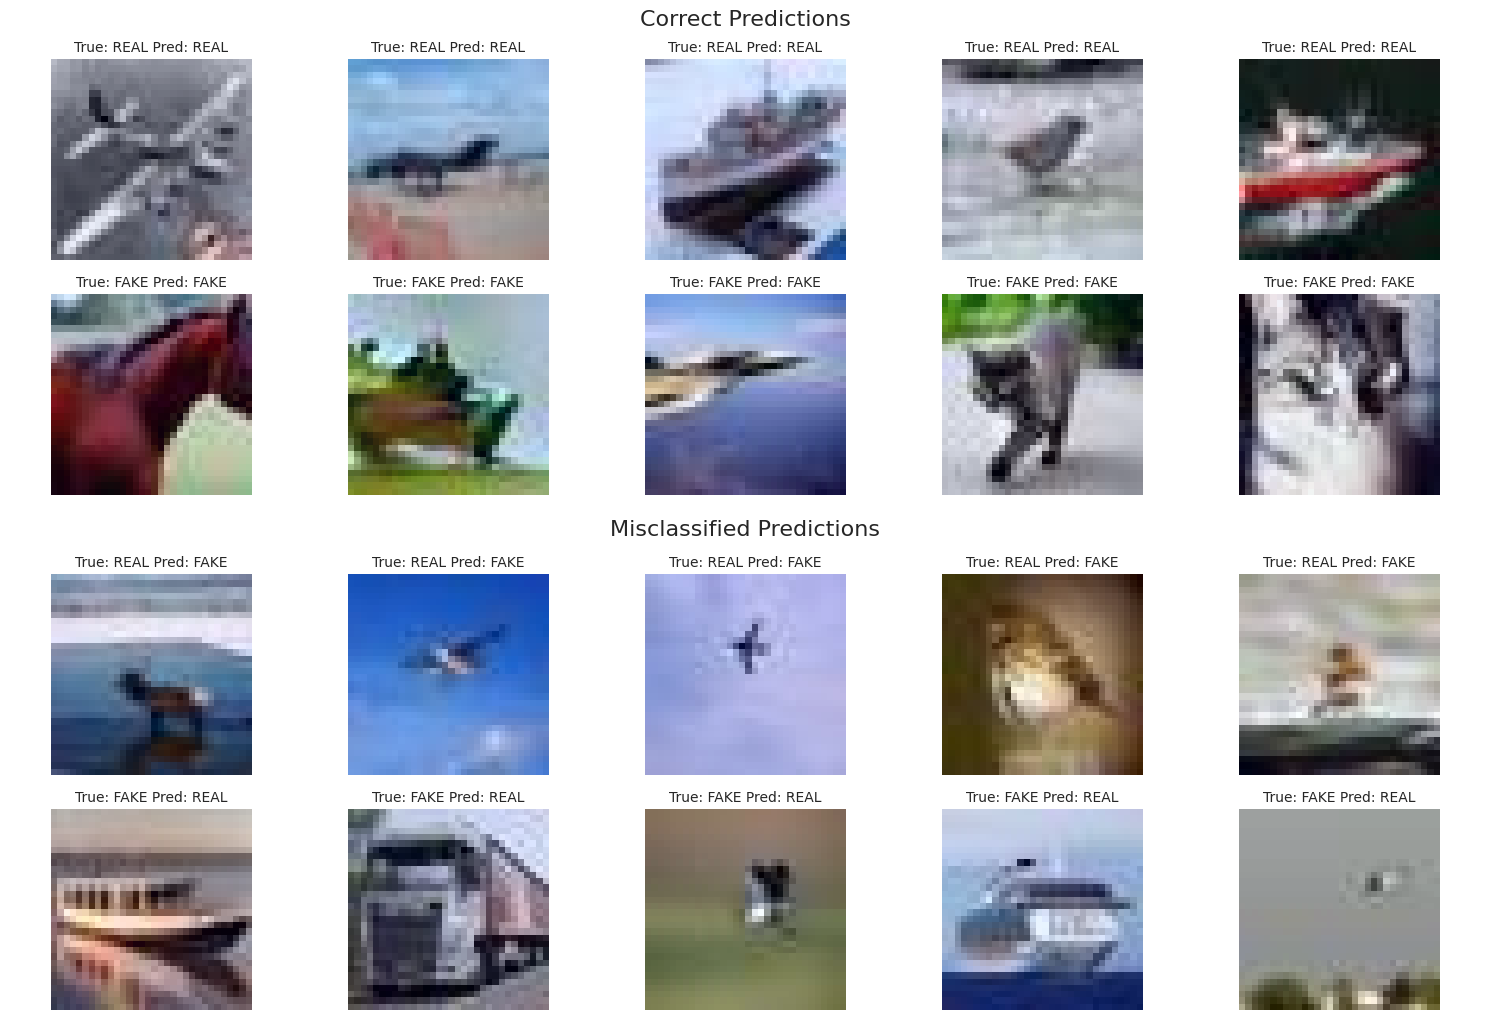

In [ ]:

def plot_predictions_by_category(model, test_loader, class_names, device, num_images_per_category):

    # Evaluate model
    model.eval()

    # Store images for each category
    category_images = {
        (0, 0): [],  # True REAL, Predicted REAL
        (1, 1): [],  # True FAKE, Predicted FAKE
        (0, 1): [],  # True REAL, Predicted FAKE
        (1, 0): []   # True FAKE, Predicted REAL
    }

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Make predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Organize images into categories
            for i in range(images.size(0)):
                true_label = labels[i].item()
                predicted_label = predicted[i].item()

                if (true_label, predicted_label) in category_images:
                    # Convert (C, H, W) to (H, W, C)
                    image = images[i].cpu().numpy().transpose(1, 2, 0)
                    # Normalize to [0, 1]
                    image = (image - image.min()) / (image.max() - image.min())
                    category_images[(true_label, predicted_label)].append((image, true_label, predicted_label))

                # Stop collecting images if we have enough for all categories
                if all(len(category_images[key]) >= num_images_per_category for key in category_images):
                    break

    # Create the figure with extra space between the second and third rows
    fig, axes = plt.subplots(
        # Add an extra row for space between sections
        len(category_images) + 1,
        num_images_per_category,
        figsize=(15, 10),
        # Add a small space between sections
        gridspec_kw={"height_ratios": [1, 1, 0.05, 1, 1]},
    )
    fig.subplots_adjust(hspace=0.5)

    # Add subtitles
    fig.text(0.5, 1, "Correct Predictions", ha="center", fontsize=16)
    fig.text(0.5, 0.49, "Misclassified Predictions", ha="center", fontsize=16)

    row_titles = [
        "True: REAL, Pred: REAL",
        "True: FAKE, Pred: FAKE",
        "Spacer",
        "True: REAL, Pred: FAKE",
        "True: FAKE, Pred: REAL",
    ]

    row_counter = 0
    for row, ((true_label, pred_label), images) in enumerate(category_images.items()):
        if row == 2:  # Skip the spacer row
            row_counter += 1
        for col in range(num_images_per_category):
            ax = axes[row + row_counter, col]
            if col < len(images):
                image, true, pred = images[col]
                ax.imshow(image)
                ax.set_title(f"True: {class_names[true]} Pred: {class_names[pred]}", fontsize=10)
                ax.axis("off")

        # Add row title for non-spacer rows
        if row != 2:
            axes[row + row_counter, 0].set_ylabel(row_titles[row + row_counter], fontsize = 12, rotation = 0, labelpad = 100, ha = "right")

    # Remove axes from the spacer row
    for col in range(num_images_per_category):
        axes[2, col].axis("off")

    plt.tight_layout()  # Adjust layout to fit the subtitles
    # Save figure
    plt.savefig('cnn_cross_entropy_old_predictions.png', format = 'png')
    plt.show()

# Define classes
class_names = ["REAL", "FAKE"]

# Plot predictions
plot_predictions_by_category(model, test_loader, class_names, device = "cpu", num_images_per_category = 5)

100%|██████████| 20000/20000 [00:03<00:00, 5051.81it/s]


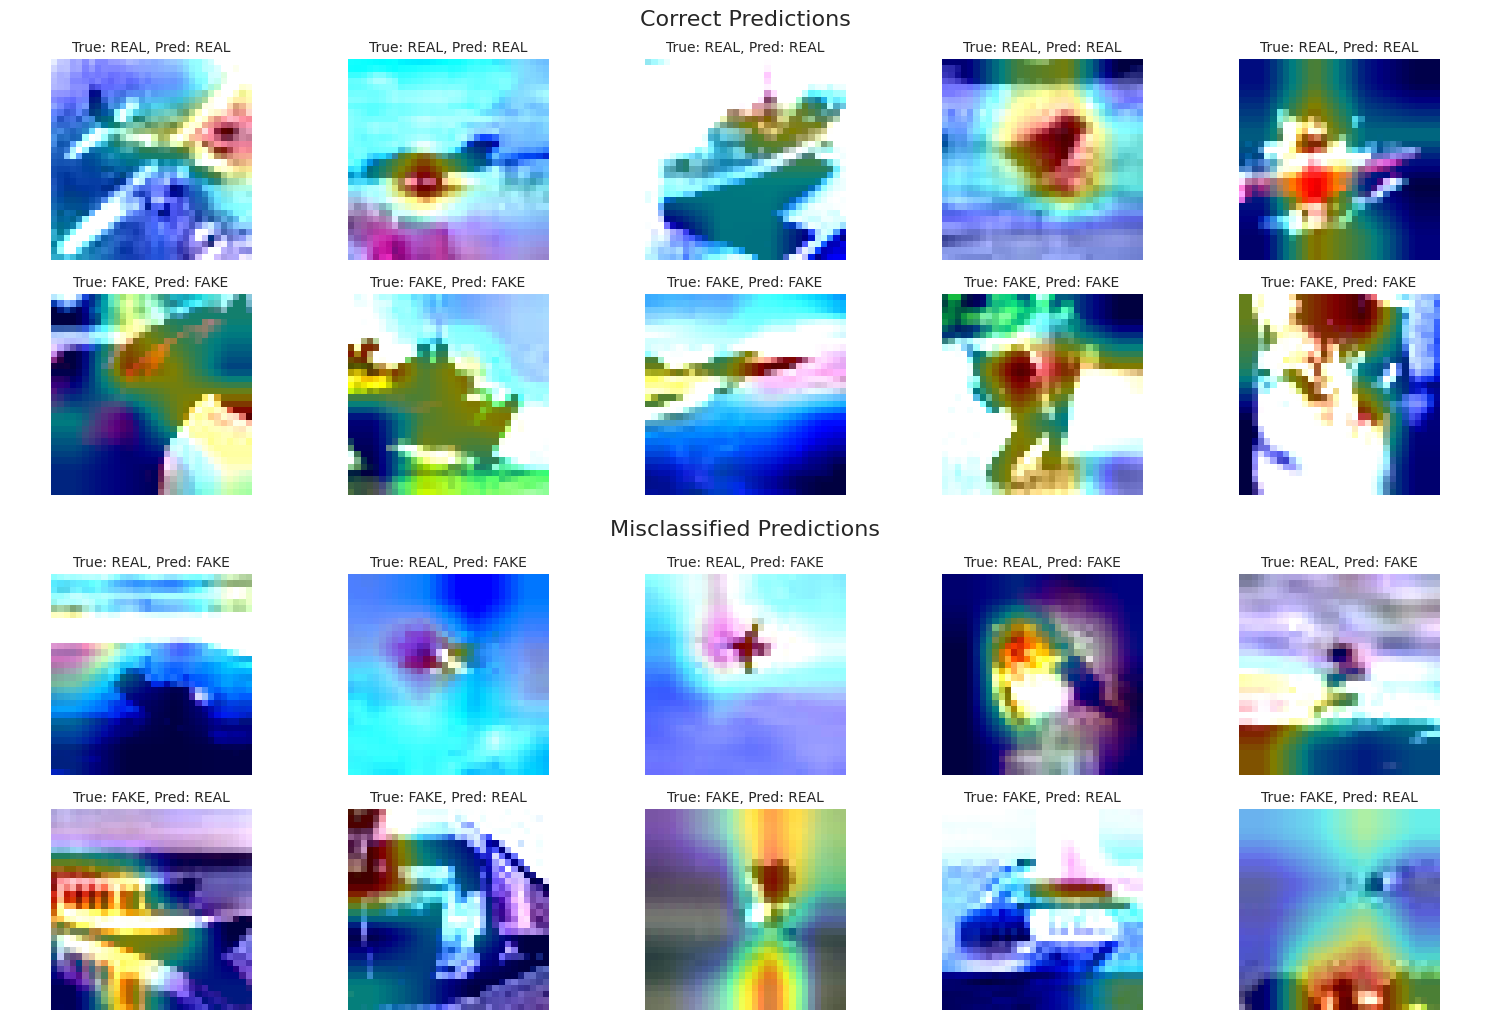

In [ ]:
def gradcam(model, image, layer_name, label_idx):
    """
    Compute GradCAM heatmap for a given image.
    """
    # Move the model to cpu
    model = model.to("cpu")
    model.eval()

    # Hook for activations and gradients
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks to the specified layer
    for name, module in model.named_modules():
        if name == layer_name:
            module.register_forward_hook(forward_hook)
            module.register_backward_hook(backward_hook)

    # Add a batch dimension to the image
    image = image.unsqueeze(0)

    # Forward pass
    output = model(image)

    # Select the target class output
    loss = output[0, label_idx]
    model.zero_grad()

    # Backward pass
    loss.backward()

    # Get the gradients and activations
    grads = gradients[0].detach().cpu().numpy()
    acts = activations[0].detach().cpu().numpy()

    # Compute weights and apply global average pooling of gradients
    weights = np.mean(grads, axis=(2, 3))
    cam = np.sum(weights[:, :, np.newaxis, np.newaxis] * acts, axis=1)

    # Normalize the heatmap
    # ReLU activation
    cam = np.maximum(cam, 0)
    # Remove batch dimension
    cam = cam[0]
    # Normalize to [0, 1]
    cam /= cam.max()

    return cam


# Compute the mean and standard deviation for all channels
mean, std = compute_mean_std(test_set_paths)

# Compute the overall average of the mean tensor across all channels
average_mean = torch.mean(mean).item()

# Compute the overall average of the standard deviation tensor across all channels
average_std = torch.mean(std).item()


def overlay_gradcam(image, average_mean, average_std, heatmap, alpha = 0.5):
    """
    Overlay Grad-CAM heatmap on the original image.
    """
    # Convert tensor to NumPy array and denormalize
    image = image.permute(1, 2, 0).numpy() * average_mean + average_std
    image = np.clip(image, 0, 1)

    # Resize heatmap to match the image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Apply a colormap to the heatmap and convert BGR to RGB
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)[..., ::-1]

    # Overlay heatmap on the image
    overlayed = np.clip(image + alpha * heatmap_colored / 255.0, 0, 1)

    return overlayed


def plot_gradcam_results(model, loader, class_names, device, target_layer, num_images):
    """
    Plot a grid of Grad-CAM visualizations for predicted images grouped by true and predicted labels.
    """
    category_images = {key: [] for key in [(0, 0), (1, 1), (0, 1), (1, 0)]}
    model.eval()

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        for i in range(images.size(0)):
            true_label, pred_label = labels[i].item(), preds[i].item()
            if (true_label, pred_label) in category_images:
                category_images[(true_label, pred_label)].append((images[i], true_label, pred_label))
            if all(len(v) >= num_images for v in category_images.values()):
                break

    # Create the figure with extra space between the second and third rows
    fig, axes = plt.subplots(
        # Add an extra row for space
        len(category_images) + 1,
        # Number of columns (images per category)
        num_images,
        figsize=(15, 10),
        # Row height ratios
        gridspec_kw={"height_ratios": [1, 1, 0.05, 1, 1]},
    )
    # Adjust space between rows
    fig.subplots_adjust(hspace=0.5)

    # Add subtitles for sections
    fig.text(0.5, 1, "Correct Predictions", ha="center", fontsize=16)
    fig.text(0.5, 0.49, "Misclassified Predictions", ha="center", fontsize=16)

    # Define row titles
    row_titles = [
        "True: REAL, Pred: REAL",
        "True: FAKE, Pred: FAKE",
        "Spacer",
        "True: REAL, Pred: FAKE",
        "True: FAKE, Pred: REAL",
    ]

    # Initialize a row counter to handle the spacer
    row_counter = 0

    # Loop through each category and its images
    for row, ((category, images), title) in enumerate(zip(category_images.items(), row_titles)):
        if row == 2:  # Skip the spacer row
            row_counter += 1

        for col in range(num_images):
          # Access the current subplot
            ax = axes[row + row_counter, col]
            # Ensure there are enough images
            if col < len(images):
                # Unpack image, true label, and prediction
                img, true, pred = images[col]
                # Compute GradCAM
                heatmap = gradcam(model, img, layer_name = target_layer, label_idx = pred)
                # Generate overlay
                overlay = overlay_gradcam(img.cpu(), average_mean, average_std, heatmap)
                # Display the overlay image
                ax.imshow(overlay)
                ax.set_title(f"True: {class_names[true]}, Pred: {class_names[pred]}", fontsize=10)
            ax.axis("off")

        # Add row title for non-spacer rows
        if row != 2:
            axes[row + row_counter, 0].set_ylabel(
                row_titles[row + row_counter],
                fontsize=12,
                rotation=0,
                labelpad=100,
                ha="right",
            )

    # Remove axes from the spacer row
    for col in range(num_images):
        axes[2, col].axis("off")

    plt.tight_layout()
    # Save figure
    plt.savefig('cnn_cross_entropy_old_gradcam.png', format = 'png')
    plt.show()

# Define classes and layer for Grad-CAM visualization
class_names = ["REAL", "FAKE"]
# Target layer
layer_name = "conv_4"

# Plot predictions with Grad-CAM
plot_gradcam_results(model, test_loader, class_names, device = "cpu", target_layer = layer_name, num_images = 5)